In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score

from time import time
import random as r

datapath = "/content/gdrive/My Drive/Datasets/Udemy/"

# Helper Functions

In [3]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
  breaker()
  print(x[:no_of_ele])
  breaker()

def getCol(x):
  return [col for col in x.columns]

def preprocess(x, *args):
  df = x.copy()
  df[args[0]] = df[args[0]].map({"France" : 0, "Spain" : 1, "Germany" : 2})
  df[args[1]] = df[args[1]].map({"Male" : 0, "Female" : 1})
  return df

sc_X = StandardScaler()

# Data Handling

**Input and Preprocessing**

In [4]:
dataset = pd.read_csv(datapath + "Churn_Modelling.csv")

breaker()
print(dataset.head(5))
breaker()
print("Dataset Shape :", repr(dataset.shape))
breaker()


dataset = dataset.drop(labels=["RowNumber", "CustomerId", "Surname"], axis=1)
dataset = preprocess(dataset, "Geography", "Gender")

features = dataset.iloc[:, :-1].copy().values
labels = dataset.iloc[:, -1].copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=2000, shuffle=True, random_state=0)

breaker()
print(X[0, :])
breaker()

X = sc_X.fit_transform(X)
X_test = sc_X.transform(X_test)

num_features = X.shape[1]

del dataset


------------------------------

   RowNumber  CustomerId   Surname  ...  IsActiveMember EstimatedSalary Exited
0          1    15634602  Hargrave  ...               1       101348.88      1
1          2    15647311      Hill  ...               1       112542.58      0
2          3    15619304      Onio  ...               0       113931.57      1
3          4    15701354      Boni  ...               0        93826.63      0
4          5    15737888  Mitchell  ...               1        79084.10      0

[5 rows x 14 columns]

------------------------------

Dataset Shape : (10000, 14)

------------------------------


------------------------------

[6.6700000e+02 1.0000000e+00 1.0000000e+00 3.4000000e+01 5.0000000e+00
 0.0000000e+00 2.0000000e+00 1.0000000e+00 0.0000000e+00 1.6383064e+05]

------------------------------



**Dataset Template**

In [5]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y
    
  def __len__(this):
    return this.X.shape[0]

  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [6]:
class CFG():
  tr_batch_size = 128
  va_batch_size = 128
  ts_batch_size = 128

  epochs = 50
  n_folds = 4

  IL = num_features
  HL_1 = [512]
  HL_2 = [512, 256]
  OL = 1

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cfg = CFG()

num_obs_test = X_test.shape[0]
ts_data_setup = DS(X_test, y_test.reshape(-1,1))
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

**Setup**

In [7]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.HL = HL

    this.DP1 = nn.Dropout(p=0.2)
    this.DP2 = nn.Dropout(p=0.5)

    if len(HL) == 1:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], OL))
    
    elif len(HL) == 2:
      this.BN1 = nn.BatchNorm1d(IL)
      this.FC1 = WN(nn.Linear(IL, HL[0]))

      this.BN2 = nn.BatchNorm1d(HL[0])
      this.FC2 = WN(nn.Linear(HL[0], HL[1]))

      this.BN3 = nn.BatchNorm1d(HL[1])
      this.FC3 = WN(nn.Linear(HL[1], OL))
    
    else:
      raise NotImplementedError("Only Allows Networks of Depth 1 and 2")

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3, weight_decay=1e-5)

  def forward(this, x):
    if len(this.HL) == 1:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC2(x))
      return x
    else:
      x = this.BN1(x)
      x = this.DP1(x)
      x = F.relu(this.FC1(x))
      x = this.BN2(x)
      x = this.DP2(x)
      x = F.relu(this.FC2(x))
      x = this.BN3(x)
      x = this.DP2(x)
      x = torch.sigmoid(this.FC3(x))
      return x

**ANN Helpers**

In [8]:
def train_fn(X=None, y=None, n_folds=None, HL_Used=None):
  breaker()
  print("Training ...")
  breaker()

  LP = []
  names = []
  bestLoss = {"train" : np.inf, "valid" : np.inf}
  fold = 0

  start_time = time()
  for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
    print("Processing Fold {fold} ...".format(fold=fold+1))

    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    tr_data_setup = DS(X_train, y_train.reshape(-1,1))
    va_data_setup = DS(X_valid, y_valid.reshape(-1,1))

    dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                   "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)}

    torch.manual_seed(0)
    model = ANN(cfg.IL, HL_Used, cfg.OL)
    model.to(cfg.device)

    optimizer = model.getOptimizer()
    #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, eps=1e-6, verbose=True)

    for e in range(cfg.epochs):
      epochLoss = {"train" : 0, "valid" : 0}
      for phase in ["train", "valid"]:
        if phase == "train":
          model.train()
        else:
          model.eval()
        lossPerPass = 0

        for feat, label in dataloaders[phase]:
          feat, label = feat.to(cfg.device), label.to(cfg.device)

          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            output = model(feat)
            loss   = nn.BCELoss()(output, label)
            if phase == "train":
              loss.backward()
              optimizer.step()
          lossPerPass = (loss.item() / label.shape[0])
        epochLoss[phase] = lossPerPass
      LP.append(epochLoss)
      #scheduler.step(epochLoss["valid"])
      if epochLoss["valid"] < bestLoss["valid"]:
        bestLoss = epochLoss
        name = "Model_{id}_Fold_{fold}.pt".format(id=len(HL_Used), fold=fold)
        names.append(name)
        torch.save(model.state_dict(), datapath+name)
    fold += 1

  breaker()
  print("Time taken to Train for ({fold} folds, {e} epochs) = {:.2f} minutes".format(float((time() - start_time)/60), fold=n_folds, e=cfg.epochs))
  breaker()
  print("Best Loss :", repr(bestLoss))
  breaker()
  return LP, names, model
  
def eval_fn(model=None, names=None, dataloader=None):
  y_pred = np.zeros((num_obs_test, 1))

  for name in names:
    Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    model.load_state_dict(torch.load(datapath+name))
    model.eval()
    for X, y in ts_data:
      X = X.to(cfg.device)
      with torch.no_grad():
        Prob = model(X)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:].cpu().numpy()
    y_pred = np.add(y_pred, Pred)

  y_pred = np.divide(y_pred, len(names))
  y_pred[np.argwhere(Pred > 0.5)[:, 0]]  = 1
  y_pred[np.argwhere(Pred <= 0.5)[:, 0]] = 0
  return y_pred.reshape(-1).astype(int)

# Network Configuration 1


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time taken to Train for (4 folds, 50 epochs) = 1.86 minutes

------------------------------

Best Loss : {'train': 0.00441097015781062, 'valid': 0.0035240922123193743}

------------------------------



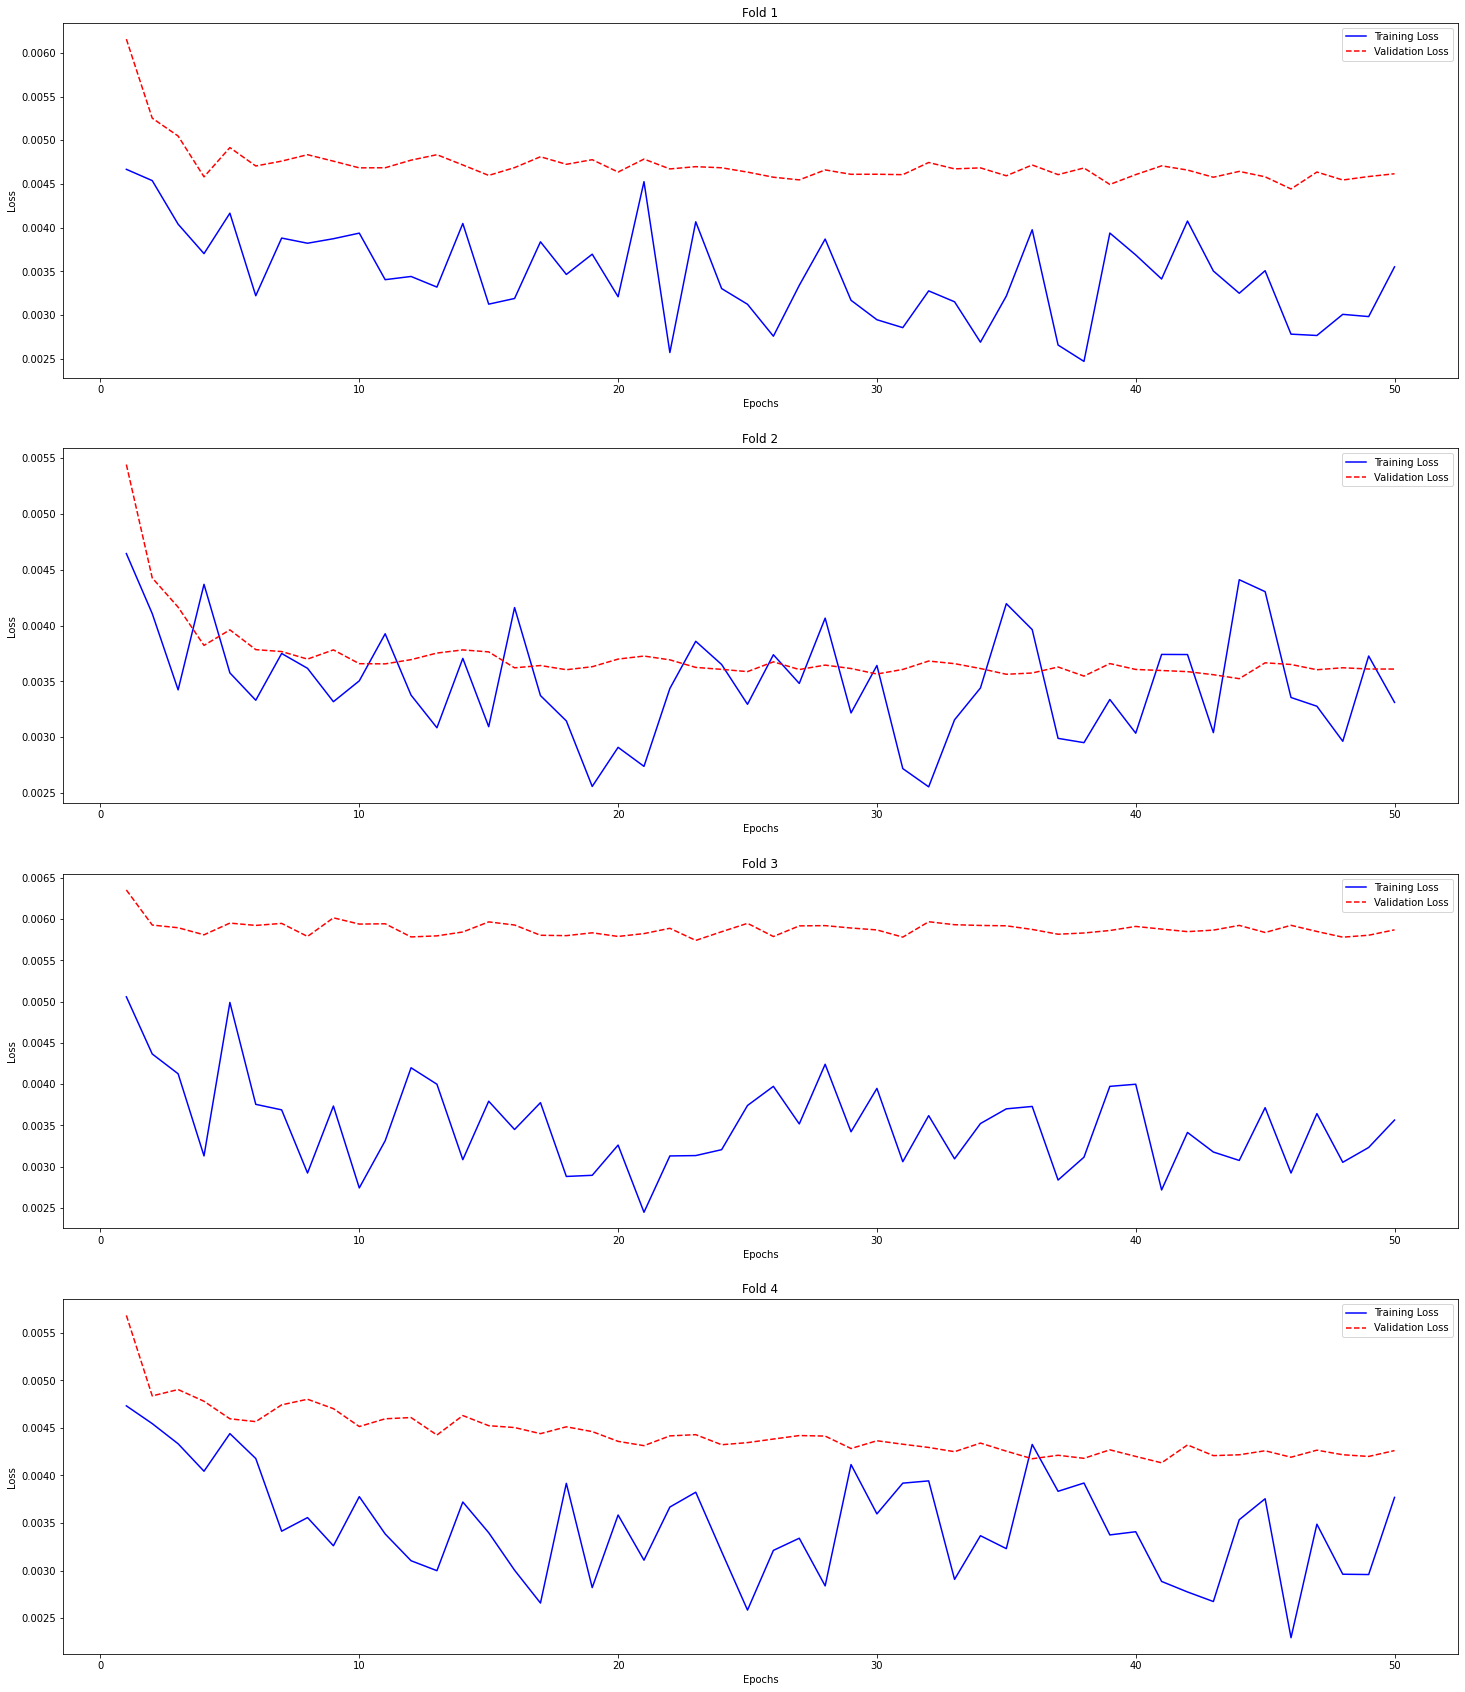


------------------------------

Accuracy : 86.10000 %

------------------------------



In [9]:
LP_1, Names_1, Network_1 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_1)

LPT = []
LPV = []

for i in range(len(LP_1)):
  LPT.append(LP_1[i]["train"])
  LPV.append(LP_1[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

y_pred = eval_fn(Network_1, set(Names_1), ts_data)

breaker()
print("Accuracy : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()

# Network Configuration 2


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Processing Fold 2 ...
Processing Fold 3 ...
Processing Fold 4 ...

------------------------------

Time taken to Train for (4 folds, 50 epochs) = 3.14 minutes

------------------------------

Best Loss : {'train': 0.0030636784753629138, 'valid': 0.0033969398587942123}

------------------------------



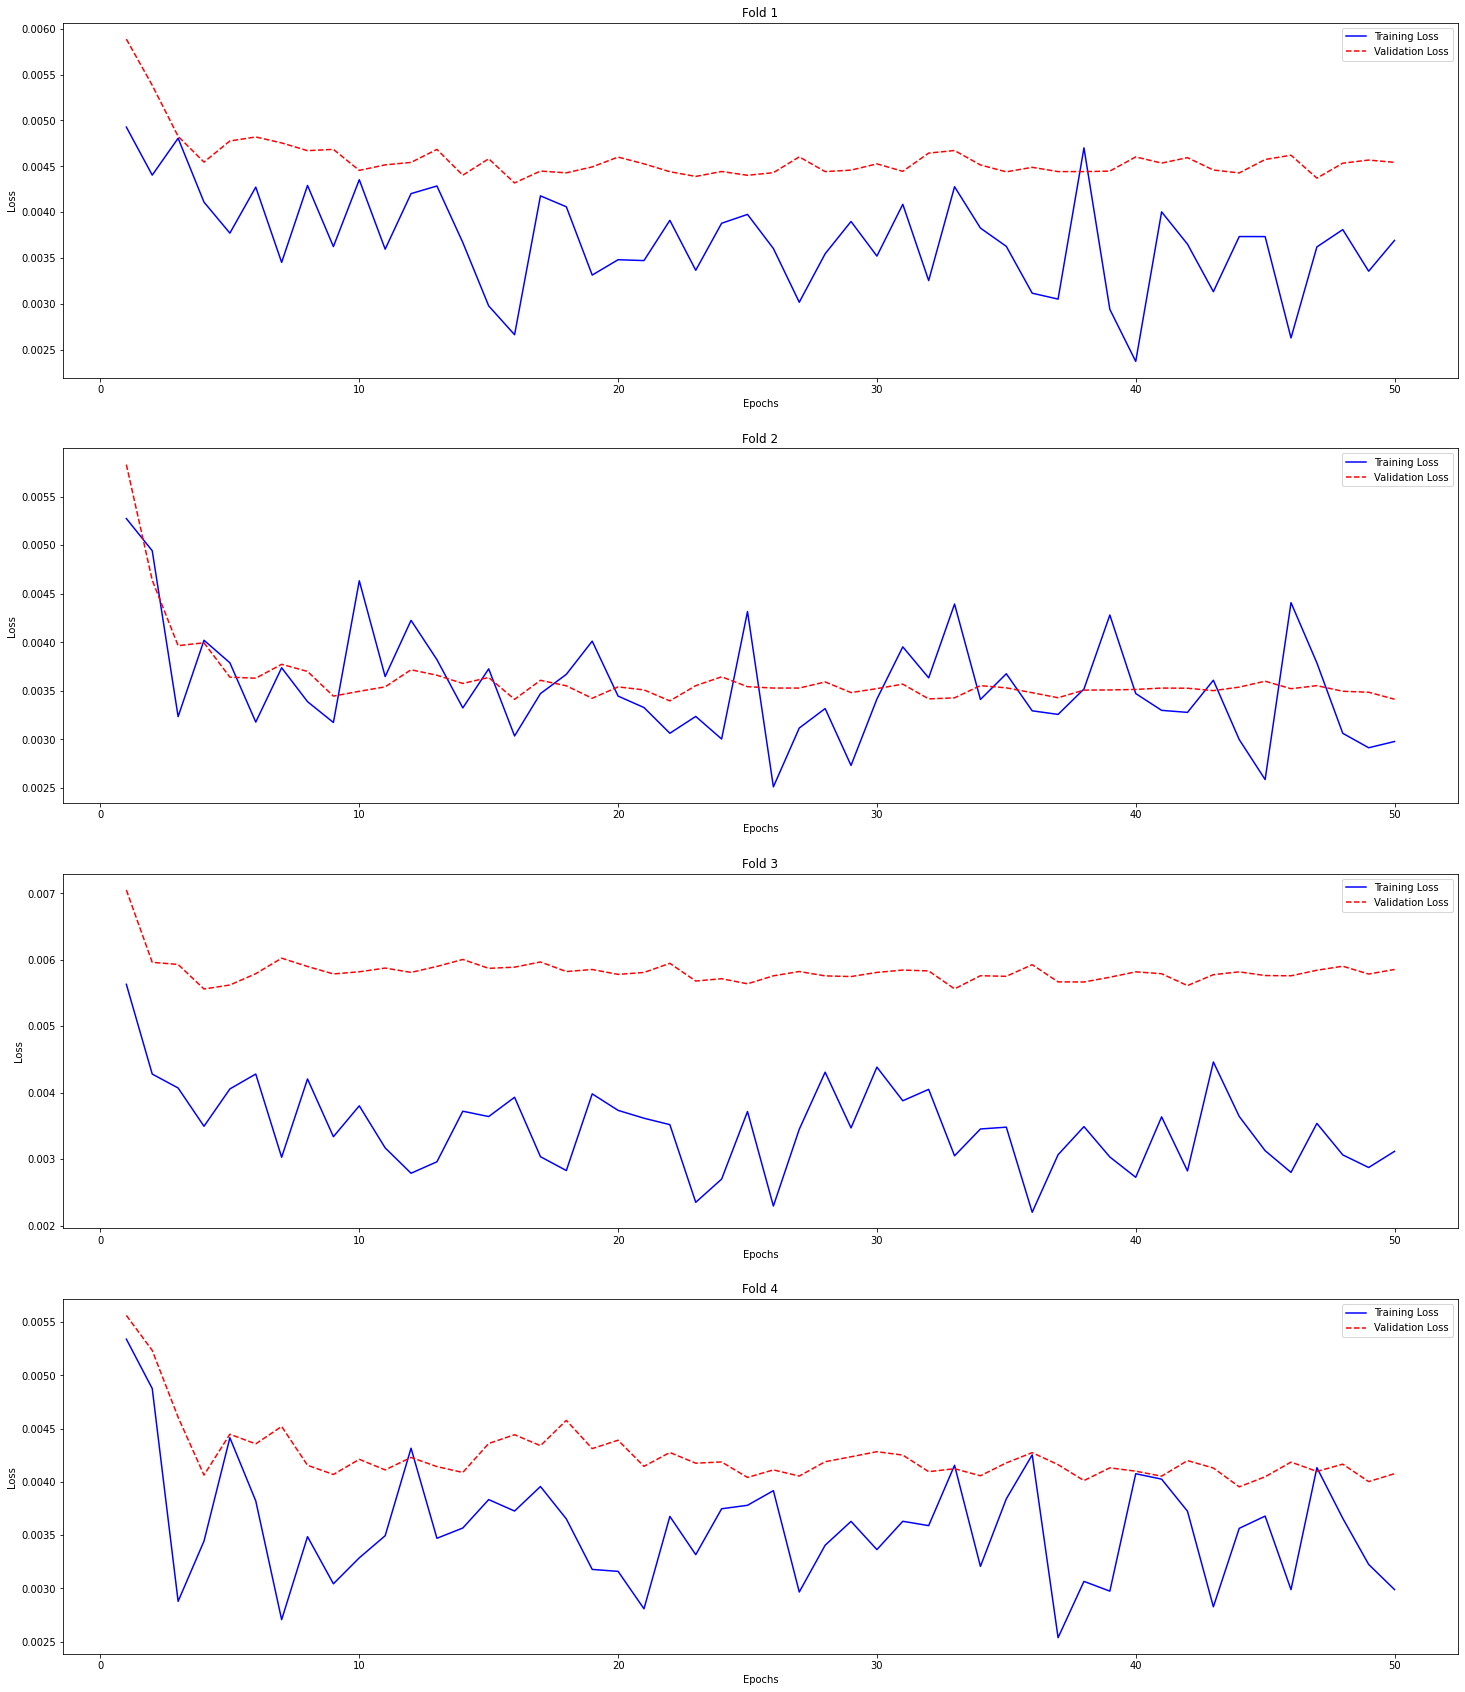


------------------------------

Accuracy : 86.05000 %

------------------------------



In [10]:
LP_2, Names_2, Network_2 = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_2)

LPT = []
LPV = []

for i in range(len(LP_2)):
  LPT.append(LP_2[i]["train"])
  LPV.append(LP_2[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

y_pred = eval_fn(Network_2, set(Names_2), ts_data)

breaker()
print("Accuracy : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()

# Ensemble

In [13]:
def ensemble_eval_fn(model_1=None, model_2=None, names_1=None, names_2=None, dataloader=None):
  y_pred_1 = np.zeros((num_obs_test, 1))
  y_pred_2 = np.zeros((num_obs_test, 1))

  for name in names_1:
    Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    model_1.load_state_dict(torch.load(datapath+name))
    model_1.eval()
    for feat, label in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_1(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_1 = np.add(y_pred_1, Pred)
  y_pred_1 = np.divide(y_pred_1, len(names_1))

  for name in names_2:
    Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    model_2.load_state_dict(torch.load(datapath+name))
    model_2.eval()
    for feat, label in dataloader:
      feat = feat.to(cfg.device)
      with torch.no_grad():
        Prob = model_2(feat)
      Pred = torch.cat((Pred, Prob), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    Pred = Pred.cpu().numpy()
    y_pred_2 = np.add(y_pred_2, Pred)
  y_pred_2 = np.divide(y_pred_2, len(names_2))

  y_pred = np.divide(np.add(y_pred_1, y_pred_2), 2)
  y_pred[np.argwhere(Pred > 0.5)[:, 0]]  = 1
  y_pred[np.argwhere(Pred <= 0.5)[:, 0]] = 0
  return y_pred.reshape(-1).astype(int)

ensemble_y_pred = ensemble_eval_fn(Network_1, Network_2, set(Names_1), set(Names_2), ts_data)

breaker()
print("Accuracy : {:.5f} %".format(accuracy_score(y_test, ensemble_y_pred) * 100))
breaker()


------------------------------

Accuracy : 86.05000 %

------------------------------

